# Load LDC-2 data (LDC-2a *Sangria* / LDC-2b Spritz data)
Load LDC-2 data (LDC-2a *Sangria* / LDC-2b Spritz data) and pack them in a convenient format to proceed with the MBHB search.

E Castelli - 2022

## 0. Settings and package import

In [1]:
# Python standard packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import h5py

## 1. Load time-domain LDC data

We are currently interested only in the impact of gaps on the Spritz MBHB-1 dataset. To achieve that we separate the effect of glitches from the effect of gaps in the Spritz data, and we do so by creating ad-hoc datasets with only gaps.

### 1.1. Download and access data

Download LDC 2b *Spritz* MBHB-1 data from the LDC official website (https://lisa-ldc.lal.in2p3.fr/challenge2b) and save them to the `./data/` folder.

In [3]:
# import data
fname = './data/LDC2_spritz_mbhb1_training_v1.h5'
# open file with h5py
fid = h5py.File(fname)

In [22]:
# define function to print all attributes of hdf5 file recursively 
# from the LDC quicklook notebooks
def print_attrs(name, obj):
    shift = name.count('/') * '    '
    print(shift + name)
    for key, val in obj.attrs.items():
        print(shift + '    ' + f"{key}: {val}")
# print all dataset attributes (useful to see what's inside the HDF5 file)
fid.visititems(print_attrs)

clean
    clean/tdi
        coord: t
        dt: 5.0
        t0: 8899200.0
        units: dimensionless
header
    header/date
instru
    instru/config
        instru/config/LISA_AAFILTER_ATTENUATION
        instru/config/LISA_AAFILTER_TRANSITION_BAND_0
        instru/config/LISA_AAFILTER_TRANSITION_BAND_1
        instru/config/LISA_ACC_NOISE_A_LEVEL
        instru/config/LISA_ACC_NOISE_F_KNEE
        instru/config/LISA_ACC_NOISE_USE_PZM
        instru/config/LISA_ADC_RECURSION_ORDER
        instru/config/LISA_BACKLINK_NOISE_A_LEVEL
        instru/config/LISA_BACKLINK_NOISE_F_KNEE
        instru/config/LISA_DEBUG_CLOCK_OFFSETS
        instru/config/LISA_FREQUENCY_OFFSETS_12
        instru/config/LISA_FREQUENCY_OFFSETS_13
        instru/config/LISA_FREQUENCY_OFFSETS_21
        instru/config/LISA_FREQUENCY_OFFSETS_23
        instru/config/LISA_FREQUENCY_OFFSETS_31
        instru/config/LISA_FREQUENCY_OFFSETS_32
        instru/config/LISA_GLITCH_FILE
        instru/config/LISA_GW_FILE_FS


#### 1.1. Import the Spritz `tdi` datasets

The Spritz HDF5 file is structured in various groups:
- group `obs` containing `noise + signal + artifacts` (gaps + glitches)
- group `clean` containing `noise + signal`
- group `sky` containing `signal`
- group `noisefree` containing `signal + artifacts` (gaps + glitches)

Each of these groups hosts a dataset `tdi` that contains TDI combinations $X$, $Y$ and $Z$.

#### 1.2. Build the missing TDI dataset
- TDI dataset containing `noise`
- TDI dataset containing `noise + signal + gaps`

In [5]:
# Print the tdi dataset object
print(fid['obs/tdi'])

<HDF5 dataset "tdi": shape (535680, 1), type "|V32">


In [6]:
from bayesdawn.connect.read_ldc_data import load_tdi_timeseries

In [7]:
tdi = load_tdi_timeseries(fname = './data/LDC2_spritz_mbhb1_training_v1.h5')
tdi

{'obs': array([( 8899200.,  1.48846573e-16,  6.75329568e-17, -3.88519717e-16),
        ( 8899205., -4.42617579e-16, -1.11055482e-16,  5.28572415e-16),
        ( 8899210., -7.98086872e-16,  7.99285081e-16, -1.47198918e-15),
        ...,
        (11577585., -9.29825703e-21, -6.92159645e-21,  7.19465308e-21),
        (11577590.,  5.70018992e-21, -9.60595627e-22, -4.94114882e-21),
        (11577595., -4.30521190e-21,  8.29781591e-21,  2.00536091e-20)],
       dtype=[('t', '<f8'), ('X', '<f8'), ('Y', '<f8'), ('Z', '<f8')]),
 'clean': array([( 8899200.,  1.48846530e-16,  6.75330625e-17, -3.88519776e-16),
        ( 8899205., -4.42617614e-16, -1.11055377e-16,  5.28572349e-16),
        ( 8899210., -7.98086900e-16,  7.99285186e-16, -1.47198925e-15),
        ...,
        (11577585., -9.25155200e-21, -7.01214434e-21,  7.23238271e-21),
        (11577590.,  5.74426785e-21, -1.04391992e-21, -4.90782302e-21),
        (11577595., -4.26376105e-21,  8.22171527e-21,  2.00825311e-20)],
       dtype=[('t', 

In [8]:
# dataset is a numpy.recarray object with the length of the data time-series and fields ['t','X','Y','Z']
print(tdi['obs'])
print(tdi['obs'].dtype)

[( 8899200.,  1.48846573e-16,  6.75329568e-17, -3.88519717e-16)
 ( 8899205., -4.42617579e-16, -1.11055482e-16,  5.28572415e-16)
 ( 8899210., -7.98086872e-16,  7.99285081e-16, -1.47198918e-15) ...
 (11577585., -9.29825703e-21, -6.92159645e-21,  7.19465308e-21)
 (11577590.,  5.70018992e-21, -9.60595627e-22, -4.94114882e-21)
 (11577595., -4.30521190e-21,  8.29781591e-21,  2.00536091e-20)]
[('t', '<f8'), ('X', '<f8'), ('Y', '<f8'), ('Z', '<f8')]


In [9]:
# set up dataset constant values

# number of samples to skip at the beginning of the file
skip = 100 
# length of time-series
ndata = len(tdi['obs'][skip:])
# time step
dt = tdi['obs']['t'][1]-tdi['obs']['t'][0]
# sampling frequency
fs = 1.0/dt

print('skip','ndata','dt', 'fs',sep='\t',end='\n------------------------------\n')
print(skip, ndata, dt, fs,sep='\t')

skip	ndata	dt	fs
------------------------------
100	535580	5.0	0.2


#### 1.3. Plot imported data:
- Datasets containing NO noise artifacts: `n+s`, `s`, `n`
- Dataset with artifacts: `n+s+g+gl`, `n+s+g`,`s+g+gl`
    
Useful LDC-provided resources and code bits to importing Spritz data taken from here: https://gitlab.in2p3.fr/LISA/LDC/-/blob/develop/notebooks/LDC2b-Spritz.ipynb

Text(0.5, 0.98, 'TDI X time-series and noise spectra')

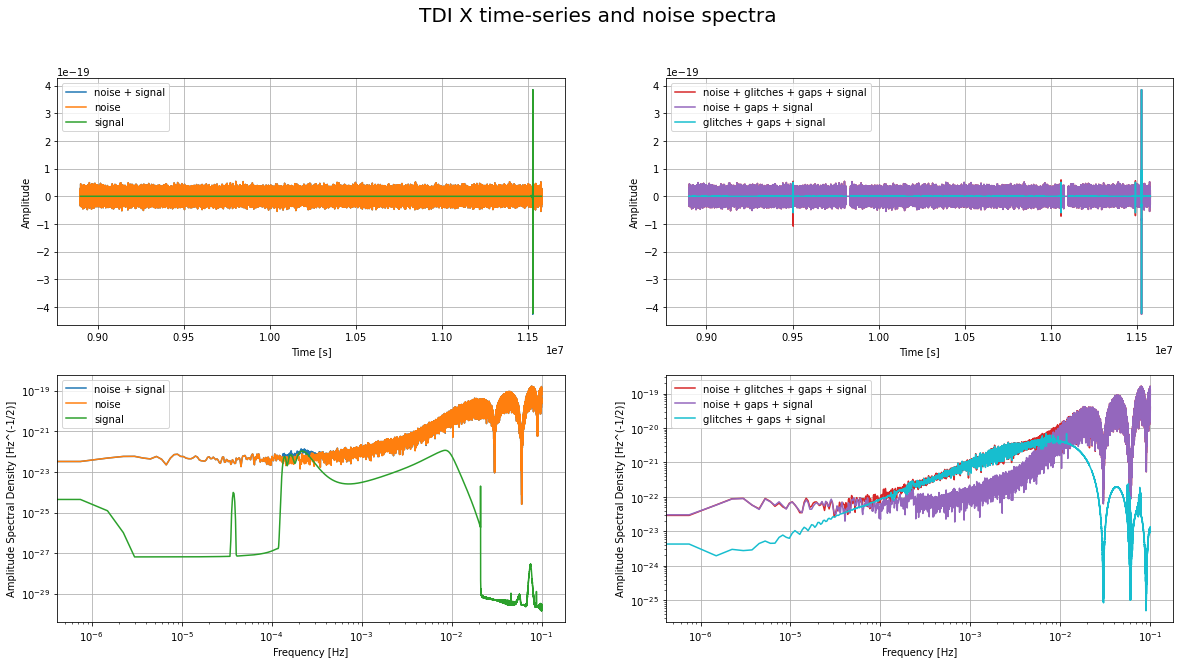

In [10]:
# plot TDI X time-series and noise spectra for all different configurations

fig, ax = plt.subplots(2, 2, figsize=(20,10))
# top left canvas
ax[0][0].plot(tdi['clean']['t'][skip:], tdi['clean']["X"][skip:], label = 'noise + signal')
ax[0][0].plot(tdi['noise']['t'][skip:], tdi['noise']["X"][skip:], label='noise')
ax[0][0].plot(tdi['sky']['t'][skip:], tdi['sky']["X"][skip:], label='signal')
ax[0][0].set_ylabel("Amplitude")
ax[0][0].set_xlabel("Time [s]")
ax[0][0].grid()
ax[0][0].legend()
# top right canvas
ax[0][1].plot(tdi['obs']['t'][skip:], tdi['obs']["X"][skip:], label='noise + glitches + gaps + signal', color='tab:red')
ax[0][1].plot(tdi['clean_gapped']['t'][skip:], tdi['clean_gapped']["X"][skip:], label='noise + gaps + signal', color='tab:purple')
ax[0][1].plot(tdi['noisefree']['t'][skip:], tdi['noisefree']["X"][skip:], label='glitches + gaps + signal', color='tab:cyan')
ax[0][1].set_ylabel("Amplitude")
ax[0][1].set_xlabel("Time [s]")
ax[0][1].grid()
ax[0][1].legend()
# bottom left canvas
f, psdX =  scipy.signal.welch(tdi['clean']["X"][skip:], fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1][0].loglog(f, np.sqrt(psdX),label = 'noise + signal')
f, psdX =  scipy.signal.welch(tdi['noise']["X"][skip:], fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1][0].loglog(f, np.sqrt(psdX),label = 'noise')
f, psdX =  scipy.signal.welch(tdi['sky']["X"][skip:], fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1][0].loglog(f, np.sqrt(psdX),label = 'signal')
ax[1][0].set_ylabel("Amplitude Spectral Density [Hz^(-1/2)]")
ax[1][0].set_xlabel("Frequency [Hz]")
ax[1][0].grid()
ax[1][0].legend()
# bottom right canvas
tdix_wo_nan = tdi['obs']["X"].copy()
tdix_wo_nan[np.isnan(tdi['obs']['X'])] = 0 # set to 0 to compute PSD
f, psdX =  scipy.signal.welch(tdix_wo_nan[skip:], fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1][1].loglog(f, np.sqrt(psdX),label = 'noise + glitches + gaps + signal', color='tab:red')

tdigapped_wo_nan = tdi['clean_gapped']["X"].copy()
tdigapped_wo_nan[np.isnan(tdi['obs']['X'])] = 0 # set to 0 to compute PSD
f, psdX =  scipy.signal.welch(tdigapped_wo_nan[skip:], fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1][1].loglog(f, np.sqrt(psdX),label = 'noise + gaps + signal', color='tab:purple')

tdinoise_wo_nan = tdi['noisefree']["X"].copy()
tdinoise_wo_nan[np.isnan(tdi['obs']['X'])] = 0 # set to 0 to compute PSD
f, psdX =  scipy.signal.welch(tdinoise_wo_nan[skip:], fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1][1].loglog(f, np.sqrt(psdX),label = 'glitches + gaps + signal', color='tab:cyan')

ax[1][1].set_ylabel("Amplitude Spectral Density [Hz^(-1/2)]")
ax[1][1].set_xlabel("Frequency [Hz]")
ax[1][1].grid()
ax[1][1].legend()

plt.suptitle('TDI X time-series and noise spectra',fontsize=20)
# fig.tight_layout()

#### 1.5 Let's take a look at the impact of gaps on the noise spectrum

Text(0.5, 0.98, 'TDI X time-series and noise spectra')

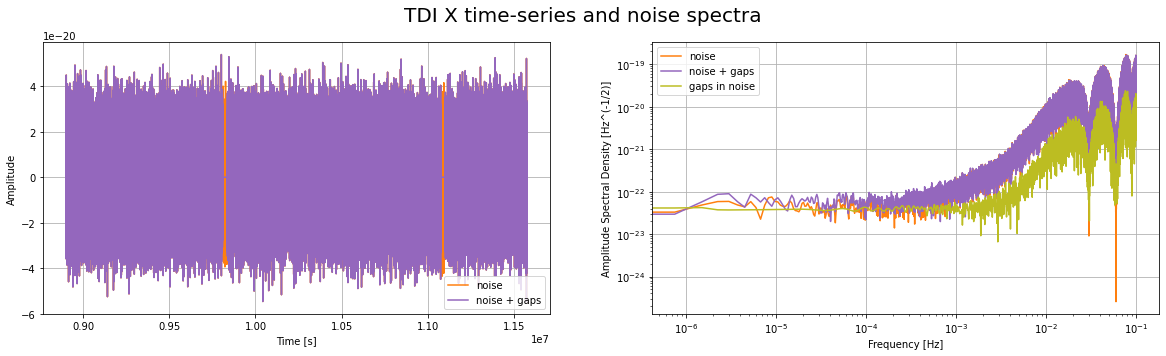

In [11]:
# plot TDI X
fig, ax = plt.subplots(1, 2, figsize=(20,5))
# top left canvas
ax[0].plot(tdi['noise']['t'][skip:], tdi['noise']["X"][skip:], label='noise', color='tab:orange')
ax[0].plot(tdi['noise_gapped']['t'][skip:], tdi['noise_gapped']["X"][skip:], label='noise + gaps', color='tab:purple')
# ax[0].plot(tdi['noise_gapped']['t'][skip:], gapdiff, label='noise + gaps + signal', color='tab:blue')
ax[0].set_ylabel("Amplitude")
ax[0].set_xlabel("Time [s]")
ax[0].grid()
ax[0].legend()
# top right canvas
f, psdX =  scipy.signal.welch(tdi['noise']["X"][skip:], fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1].loglog(f, np.sqrt(psdX),label = 'noise', color='tab:orange')

tdinoisegapped_wo_nan = tdi['noise_gapped']["X"].copy()
tdinoisegapped_wo_nan[np.isnan(tdi['obs']['X'])] = 0 # set to 0 to compute PSD
f, psdXgap =  scipy.signal.welch(tdinoisegapped_wo_nan[skip:], fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1].loglog(f, np.sqrt(psdXgap),label = 'noise + gaps', color='tab:purple')

gapdiff = tdinoisegapped_wo_nan[skip:] - tdi['noise']["X"][skip:]
f, psddiff =  scipy.signal.welch(gapdiff, fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1].loglog(f, np.sqrt(psddiff),label = 'gaps in noise', color='tab:olive')
ax[1].set_ylabel("Amplitude Spectral Density [Hz^(-1/2)]")
ax[1].set_xlabel("Frequency [Hz]")
ax[1].grid()
ax[1].legend()

plt.suptitle('TDI X time-series and noise spectra',fontsize=20)

#### 1.6. Let's take a look at the impact of gaps on the signal spectrum

Text(0.5, 0.98, 'TDI X time-series and noise spectra')

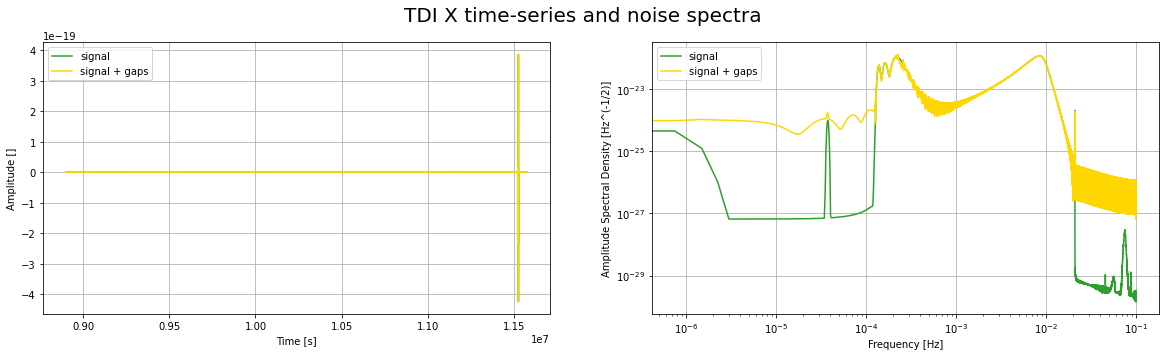

In [12]:
# plot TDI X
fig, ax = plt.subplots(1, 2, figsize=(20,5))
# top left canvas
ax[0].plot(tdi['sky']['t'][skip:], tdi['sky']["X"][skip:], label='signal', color='tab:green')
ax[0].plot(tdi['sky_gapped']['t'][skip:], tdi['sky_gapped']["X"][skip:], label='signal + gaps', color='gold')
# ax[0].plot(tdi['noise_gapped']['t'][skip:], gapdiff, label='noise + gaps + signal', color='tab:blue')
ax[0].set_ylabel("Amplitude []")
ax[0].set_xlabel("Time [s]")
ax[0].grid()
ax[0].legend()
# top right canvas
f, psdX =  scipy.signal.welch(tdi['sky']["X"][skip:], fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1].loglog(f, np.sqrt(psdX),label = 'signal', color='tab:green')

tdiskygapped_wo_nan = tdi['sky_gapped']["X"].copy()
tdiskygapped_wo_nan[np.isnan(tdi['obs']['X'])] = 0 # set to 0 to compute PSD
f, psdXgap =  scipy.signal.welch(tdiskygapped_wo_nan[skip:], fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1].loglog(f, np.sqrt(psdXgap),label = 'signal + gaps', color='gold')
ax[1].set_ylabel("Amplitude Spectral Density [Hz^(-1/2)]")
ax[1].set_xlabel("Frequency [Hz]")
ax[1].grid()
ax[1].legend()

plt.suptitle('TDI X time-series and noise spectra',fontsize=20)

## 2. Build orthogonal TDI combinations

We can proceed in two different ways to build orthogonal TDI combinations for all the datasets of our interest, i.e. `n+s`, `s`, `n`, `n+s+g` `n+g` data, according to our needs.

1. We can create separate numpy rec-arrays, one for each separate dataset
2. We can create a dictionary containing orthogonal TDI combinations for all imported datasets them


Each of these can then be wired into the Spritz analysis 

In [13]:
from bayesdawn.connect.read_ldc_data import build_orthogonal_tdi

In [21]:
# option 1 - separate numpy rec-arrays
datans = build_orthogonal_tdi(tdi['clean'])
datas  = build_orthogonal_tdi(tdi['sky'])
datan  = build_orthogonal_tdi(tdi['noise'])
datag  = build_orthogonal_tdi(tdi['clean_gapped'])
datang = build_orthogonal_tdi(tdi['noise_gapped'])
print(datans.dtype.names)

# option 2 - single dictionary containing all numpy recarrays
data = build_orthogonal_tdi(tdi)
print(data.keys())
print(data['obs'].dtype.names)

('t', 'A', 'E', 'T')
dict_keys(['obs', 'clean', 'sky', 'noisefree', 'noise', 'clean_gapped', 'noise_gapped', 'sky_gapped'])
('t', 'A', 'E', 'T')
